In [1]:
from Architectures.VAE import VAE
from Data.load import load
from matplotlib import pyplot as plt
import numpy as np

In [2]:
train, test = load("Pre-processed", take=50)

Loading images: 100%|██████████| 50/50 [00:26<00:00,  1.90it/s]


In [9]:
ae = VAE(train.shape,halvings=4, latent_dim=300, output_activation="tanh")

Interpreted image shape: (80, 96, 80, 1)
Pre-flattened latent shape: (None, 5, 6, 5, 64)


-0.4961083691975153 0.8726422589210117


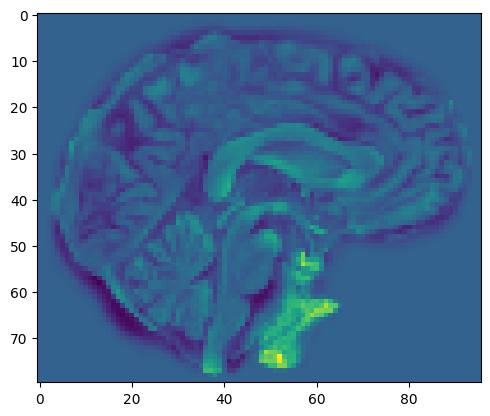

In [4]:
# Train on the diff to the mean brain instead
mean_brain = np.mean(train, axis=0)
diff_train = train - mean_brain
diff_test = test - mean_brain
plt.imshow(np.rot90(diff_train[0][40]))
print(np.min(diff_train), np.max(diff_train))

In [30]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, activations, Model

# Define the sampling function for the reparameterization trick
class Sampling(layers.Layer):
    def call(self, inputs):
        mu, logvar = inputs
        batch = tf.shape(mu)[0]
        dim = tf.shape(mu)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return mu + tf.exp(0.5 * logvar) * epsilon

# Define the VAE model
class VAE(keras.Model):
    def __init__(
            self,
            input_shape,
            halvings=4,
            init_hidden_depth=8,
            latent_dim=1_000,
            output_activation="tanh",
            lambda_=1e-5,
            hidden_activation=activations.leaky_relu
            ):
        super(VAE, self).__init__()
        self.lambda_ = lambda_

        shape_changed=False
        if input_shape[-1]>3:
            input_shape = list(input_shape) + [1]
            shape_changed=True
        if len(input_shape)>4:
            input_shape = input_shape[-4:]
            shape_changed=True
        if shape_changed: print(f"Interpreted image shape: {tuple(input_shape)}")

        # Encoder
        encoder_input = x = layers.Input(shape=input_shape)
        depth = init_hidden_depth
        for _ in range(halvings):
            x = layers.Conv3D(depth, (3, 3, 3), strides=2, activation=hidden_activation, padding="same")(x)
            x = layers.Dropout(0.05)(x)
            depth <<= 1

        pre_flatten_shape = x.shape
        print(f"Pre-flattened latent shape: {pre_flatten_shape}")
        x = layers.Flatten()(x)
        
        z_mean = layers.Dense(latent_dim, name="z_mean")(x)
        z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
        z = Sampling()([z_mean, z_log_var])
        
        self.encoder = Model(encoder_input, [z_mean, z_log_var, z], name="encoder")

        # Decoder
        decoder_input = layers.Input(shape=(latent_dim,))
        x = layers.Dense(pre_flatten_shape[1] * pre_flatten_shape[2] * pre_flatten_shape[3] * pre_flatten_shape[4], activation="relu")(decoder_input)
        x = layers.Reshape(pre_flatten_shape[1:])(x)
        
        for _ in range(halvings):
            depth >>= 1
            x = layers.Conv3D(depth, (3, 3, 3), activation=hidden_activation, padding="same")(x)
            x = layers.UpSampling3D((2, 2, 2))(x)
        decoded = layers.Conv3D(1, (3, 3, 3), activation=output_activation, padding="same")(x)
        self.decoder = Model(decoder_input, decoded, name="decoder")
        
    def call(self, inputs):
        z, mu, logvar = self.encoder(inputs)
        reconstructed = self.decoder(z)
        kl_loss = -0.5 * tf.reduce_sum(1 + logvar - tf.square(mu) - tf.exp(logvar))*self.lambda_
        self.add_loss(kl_loss)
        return reconstructed

# Instantiate the VAE model
latent_dim = 20
vae = VAE(train.shape,latent_dim=latent_dim,halvings=3, lambda_=5e-4)
vae.compile(optimizer=keras.optimizers.Adam(), loss="mse")
vae.summary()

Interpreted image shape: (80, 96, 80, 1)
Pre-flattened latent shape: (None, 10, 12, 10, 32)


Model: "vae_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Functional)            │ [(None, 20), (None,    │     1,553,592 │
│                                 │ 20), (None, 20)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 80, 96, 80, 1)  │       851,601 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,405,193 (9.18 MB)

 Trainable params: 2,405,193 (9.18 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
vae.fit(train, train, epochs=40, batch_size=100, verbose=True)

Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.1949
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.2222
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1381
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1284
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1512
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1201
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1086
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1211
Epoch 9/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1153
Epoch 10/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1054
Epoch 11/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1010
Epoch 12/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1122
Epoch 13/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1090
Epoch 14/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1238
Epoch 15/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1124
Epoch 16/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1077
E

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


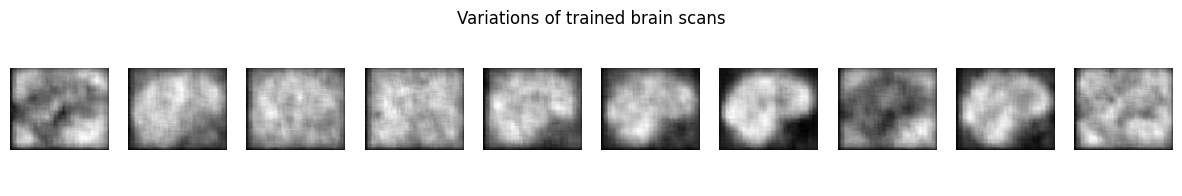

In [7]:
num_samples = 10
random_latent_vectors = np.random.normal(size=(num_samples, latent_dim))
generated_images = vae.decoder.predict(random_latent_vectors)

plt.figure(figsize=(15, 2))
plt.title("Variations of trained brain scans")
plt.axis("off")
for i in range(num_samples):
    ax = plt.subplot(1, num_samples, i + 1)
    plt.imshow(np.rot90(generated_images[i,40,:,:]), cmap="gray")
    ax.axis("off")
plt.show()

In [11]:
latent = vae.encoder(diff_test)
recon = vae.decoder(latent)
plt.imshow(np.rot90(recon[0][40]),cmap="gray")

ValueError: Layer "decoder" expects 1 input(s), but it received 3 input tensors. Inputs received: [<tf.Tensor: shape=(5, 20), dtype=float32, numpy=
array([[-0.10409513, -0.05109903, -0.11760604, -0.0026955 , -0.09964522,
        -0.092817  , -0.09851177, -0.07900846, -0.08592484, -0.06197032,
        -0.0911129 , -0.14856708, -0.0781872 , -0.13375065, -0.1507367 ,
        -0.06899714, -0.06074976, -0.0739118 , -0.09506773, -0.08136569],
       [-0.15148549, -0.11411434, -0.19211629, -0.06931029, -0.1726993 ,
        -0.17365451, -0.14961202, -0.14801136, -0.14873193, -0.12104184,
        -0.14435461, -0.22444177, -0.13371648, -0.20537204, -0.22790985,
        -0.1583837 , -0.11342688, -0.14113604, -0.14291973, -0.14525424],
       [-0.1694231 , -0.11974815, -0.15857667, -0.0599273 , -0.17103943,
        -0.19089568, -0.1693179 , -0.14909887, -0.15651141, -0.13821854,
        -0.15442307, -0.21423553, -0.13192452, -0.22196884, -0.2038223 ,
        -0.13559377, -0.11512969, -0.12973319, -0.15299241, -0.1546542 ],
       [-0.11378808, -0.06590565, -0.11159965, -0.02184904, -0.10140387,
        -0.10747738, -0.10887806, -0.09611381, -0.08057   , -0.07554518,
        -0.10528863, -0.13693553, -0.09448298, -0.13769452, -0.16762751,
        -0.07210887, -0.06522325, -0.07620156, -0.09650829, -0.08913832],
       [-0.12056673, -0.03214377, -0.0829045 ,  0.0196437 , -0.09667908,
        -0.08934095, -0.1183689 , -0.06947965, -0.06363978, -0.06240842,
        -0.08083665, -0.11806314, -0.06790479, -0.11972431, -0.12708019,
        -0.03290658, -0.04238565, -0.04460986, -0.09211532, -0.08316797]],
      dtype=float32)>, <tf.Tensor: shape=(5, 20), dtype=float32, numpy=
array([[-0.09178128, -0.08797869, -0.09788597,  0.06098223, -0.08728947,
        -0.1409003 , -0.141203  , -0.0869178 , -0.09018192, -0.05632633,
        -0.05996891, -0.10238097, -0.08021302, -0.07591411, -0.13029127,
        -0.05330753, -0.05147114, -0.11603401, -0.10644029, -0.06884163],
       [-0.11830727, -0.11180681, -0.12530021,  0.01832697, -0.11352079,
        -0.16071966, -0.16804741, -0.11513828, -0.11161452, -0.0906591 ,
        -0.08966284, -0.14563681, -0.11589639, -0.09815578, -0.16110764,
        -0.07801467, -0.07055029, -0.14022952, -0.13817635, -0.08394378],
       [-0.12412841, -0.11313757, -0.13277592,  0.0323467 , -0.11153389,
        -0.1597428 , -0.1766801 , -0.1280451 , -0.11966528, -0.08756901,
        -0.09902506, -0.12655427, -0.10840182, -0.12372022, -0.17268002,
        -0.07797571, -0.09614363, -0.16503637, -0.14857304, -0.10662451],
       [-0.09223455, -0.09416223, -0.10194781,  0.04466058, -0.08142354,
        -0.13748686, -0.14229856, -0.09280212, -0.08668701, -0.064187  ,
        -0.06098535, -0.09902348, -0.08084649, -0.0789101 , -0.13825433,
        -0.04392585, -0.05430319, -0.12047236, -0.11026524, -0.06295022],
       [-0.10761201, -0.09244418, -0.09469973,  0.08813672, -0.08803982,
        -0.14544359, -0.16008972, -0.09713838, -0.08949909, -0.06705306,
        -0.05345094, -0.0922418 , -0.07526782, -0.08581726, -0.1397249 ,
        -0.03881508, -0.04843518, -0.1152877 , -0.11332822, -0.07133529]],
      dtype=float32)>, <tf.Tensor: shape=(5, 20), dtype=float32, numpy=
array([[-2.5497574e-01, -1.6133988e+00,  2.2807768e-01,  8.8513309e-01,
        -1.4893434e+00, -2.5099784e-01,  2.5367302e-01, -2.7370725e-02,
         1.5214953e+00,  8.7280524e-01, -5.5238748e-01,  4.1034830e-01,
         1.5326248e+00, -2.6154001e+00, -4.4554293e-01,  1.3386632e+00,
        -3.0295166e-01,  4.1495317e-01, -5.3696615e-01, -4.6570456e-01],
       [-3.6919361e-01, -3.7427270e-01, -3.2623631e-01,  4.6687132e-01,
         1.4904541e+00,  3.5192484e-01,  1.4498253e-01,  4.0765345e-02,
        -9.5577866e-01, -8.7674171e-02,  1.9844094e-01,  1.6845432e-01,
         1.5659352e-01,  3.2397050e-01,  3.1187141e-01,  5.9274864e-01,
        -4.7916615e-01,  1.7597814e-01, -1.5198351e+00,  1.8596260e-01],
       [-2.3438582e+00, -1.4112395e+00,  7.5276428e-01,  4.4174257e-01,
        -2.9858792e-01, -3.2766980e-01,  1.3963103e+00,  5.0890124e-01,
        -9.2004824e-01, -4.6957213e-01, -5.0485528e-01,  1.2535255e+00,
        -2.2395352e-01, -4.0617883e-02, -4.7291690e-01,  5.1072210e-01,
        -8.4277862e-01, -8.7828726e-01,  5.1515543e-01,  8.2710928e-01],
       [-4.4500756e-01,  1.8013009e+00, -3.1276000e-01,  8.1428558e-01,
         5.2677721e-01,  2.9143244e-01, -1.4488231e+00, -4.0397933e-01,
         9.4957483e-01,  2.0235890e-01, -1.1098379e+00,  7.7959663e-01,
         1.2309951e-01, -1.1562498e+00,  2.0703501e-01,  1.3752134e+00,
         8.1021056e-02,  1.4903486e+00, -1.2696041e+00, -6.2481374e-02],
       [ 2.8485887e-02,  2.0738281e-03, -1.0835416e+00, -9.8456472e-01,
        -5.6063610e-01,  2.0309082e-01, -3.3032247e-01, -6.2504417e-01,
        -7.4680406e-01,  7.2164476e-01,  8.1016433e-01, -1.1323466e+00,
        -3.1446320e-01, -1.8531524e+00,  8.8050115e-01,  1.3020388e+00,
        -3.2257590e-01, -1.4560817e-02, -5.3661942e-01,  2.8806388e-01]],
      dtype=float32)>]

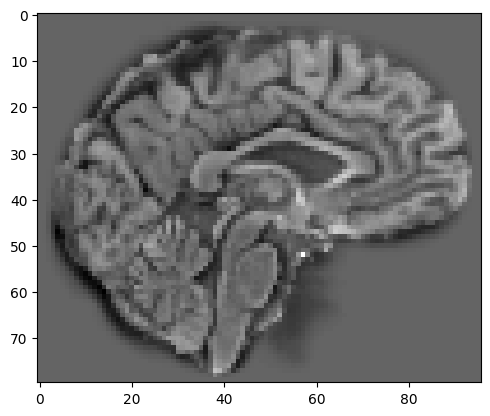

In [ ]:
plt.imshow(np.rot90(diff_test[0][40].reshape((96,80))),cmap="gray") # mean_brain[40]+

In [ ]:
from Metrics.metrics import NMSE, SSIM
SSIM(recon.reshape(diff_test.shape), diff_test)

0.47985097879764366

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step


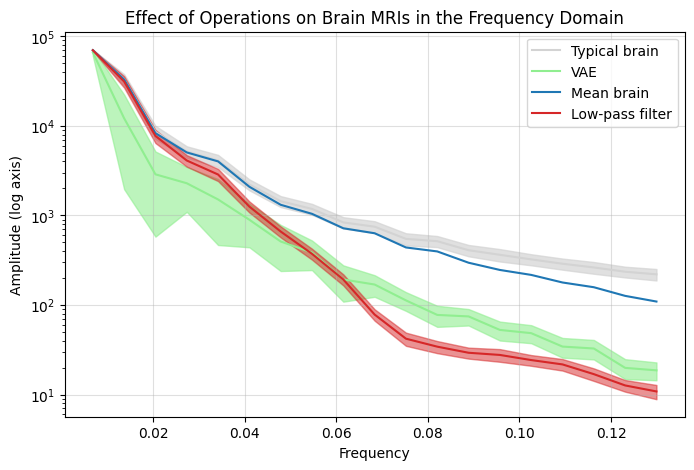

In [278]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter

legends = set()

def compute_fft(mri_scan):
    """Computes the binned amplitude spectrum for a given MRI scan."""
    fft_result = np.fft.fftn(mri_scan)
    amplitude_spectrum = np.abs(fft_result)
    
    # Compute frequency bins
    freqs_x = np.fft.fftfreq(mri_scan.shape[0])
    freqs_y = np.fft.fftfreq(mri_scan.shape[1])
    freqs_z = np.fft.fftfreq(mri_scan.shape[2])
    
    freq_magnitude = np.sqrt(freqs_x[:, None, None]**2 + freqs_y[None, :, None]**2 + freqs_z[None, None, :]**2)
    
    # Flatten
    freq_magnitude_flat = freq_magnitude.flatten()
    amplitude_flat = amplitude_spectrum.flatten()
    
    # Bin data
    bins = np.linspace(0, np.max(freq_magnitude_flat) * 0.15, num=20)
    bin_indices = np.digitize(freq_magnitude_flat, bins)
    
    binned_amplitude = np.array([
        amplitude_flat[bin_indices == i].mean() if np.any(bin_indices == i) else 0 
        for i in range(len(bins))
    ])
    
    binned_amplitude = np.clip(binned_amplitude, 0, 70_000)
    
    return bins[1:], binned_amplitude[1:]

def plot_with_confidence_interval(binned_data_list, label, color, alpha=0.3):
    """Plots mean FFT spectrum with confidence interval (std dev shading)."""
    bins = binned_data_list[0][0]
    amplitudes = np.array([data[1] for data in binned_data_list])
    
    mean_amplitude = np.mean(amplitudes, axis=0)
    std_amplitude = np.std(amplitudes, axis=0)

    plt.plot(bins, mean_amplitude, label=label, color=color)
    plt.fill_between(bins, mean_amplitude - std_amplitude, mean_amplitude + std_amplitude, color=color, alpha=alpha)

# Initialize figure
plt.figure(figsize=(8, 5))
plt.xlabel("Frequency")
plt.ylabel("Amplitude (log axis)")
plt.title("Effect of Operations on Brain MRIs in the Frequency Domain")

# Compute confidence intervals for train images
binned_data_train = [compute_fft(im) for im in train]
plot_with_confidence_interval(binned_data_train, "Typical brain", "lightgray", alpha=0.7)

# Generate some VAE images
num_samples = 100
random_latent_vectors = np.random.normal(size=(num_samples, latent_dim))
generated_images = vae.decoder.predict(random_latent_vectors)

# Compute confidence intervals for VAE-generated images
binned_data_vae = [compute_fft(im) for im in generated_images]
plot_with_confidence_interval(binned_data_vae, "VAE", "lightgreen", alpha=0.6)

# Plot individual spectra for key references
bins, mean_spectrum = compute_fft(mean_brain)
plt.plot(bins, mean_spectrum, label="Mean brain", color="tab:blue")

binned_data_vae = [compute_fft(uniform_filter(im, 15)) for im in train]
plot_with_confidence_interval(binned_data_vae, "Low-pass filter", "tab:red", alpha=0.5)

# Set scale and show legend
plt.yscale("log")
plt.legend()
plt.grid(True,alpha=0.4)
plt.show()


## How does latent space clustering in VAE compare to regular AE? 

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(2)
latent_pca = pca.fit_transform(latent)
plt.scatter(latent_pca[0,:],latent_pca[1,:])

In [ ]:
# Extract the mid-plane slice (40th slice along the first axis)
midplane_scan = mri_scan[40, :, :]

# Compute the 2D FFT on the mid-plane
fft_midplane = np.fft.fft2(midplane_scan)

# Compute the amplitude spectrum
amplitude_midplane = np.abs(fft_midplane)

# Compute frequency bins for the 2D FFT
freqs_x = np.fft.fftfreq(midplane_scan.shape[0])
freqs_y = np.fft.fftfreq(midplane_scan.shape[1])
freq_magnitude_mid = np.sqrt(freqs_x[:, None]**2 + freqs_y[None, :]**2)

# Flatten arrays
freq_magnitude_mid_flat = freq_magnitude_mid.flatten()
amplitude_mid_flat = amplitude_midplane.flatten()

# Bin the data
bins_mid = np.linspace(0, np.max(freq_magnitude_mid_flat), num=90)
bin_indices_mid = np.digitize(freq_magnitude_mid_flat, bins_mid)
binned_amplitude_mid = [amplitude_mid_flat[bin_indices_mid == i].mean() if np.any(bin_indices_mid == i) else 0 for i in range(len(bins_mid))]

# Plot amplitude vs frequency for the midplane
plt.figure(figsize=(8, 5))
plt.plot(bins_mid, binned_amplitude_mid, label="Midplane Amplitude Spectrum", color="r")
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.title("Amplitude vs Frequency Spectrum of Midplane MRI Slice")
plt.legend()
plt.yscale("log")
plt.grid(True)
plt.show()

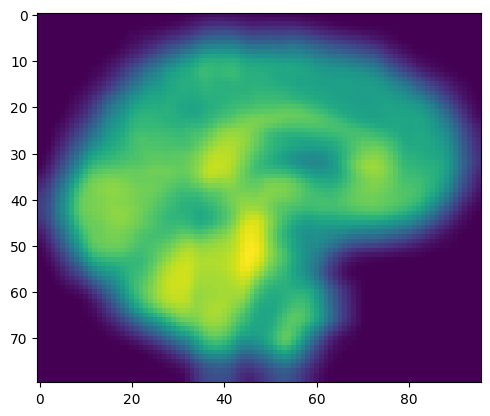

In [277]:
plt.imshow(np.rot90((uniform_filter(train[0],10))[40]))

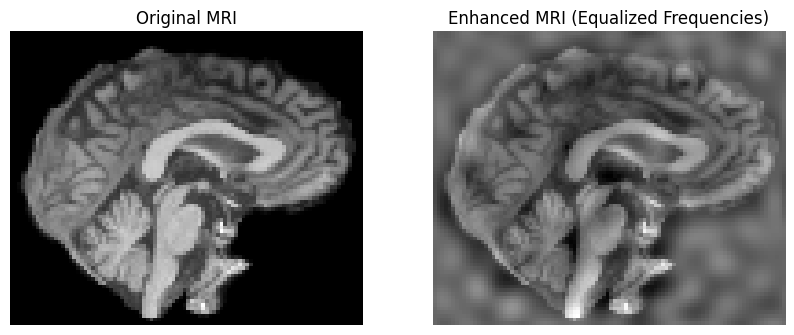

: 

In [ ]:
import numpy as np

def equalize_low_frequencies(mri_scan, target_freq=0.12):
    """
    Equalizes the amplitude of frequencies below target_freq in an MRI scan.
    
    Args:
        mri_scan (ndarray): The input 3D MRI scan.
        target_freq (float): The frequency threshold below which amplitudes are equalized.

    Returns:
        ndarray: The processed MRI scan with enhanced details.
    """
    # Compute the 3D FFT
    fft_result = np.fft.fftn(mri_scan)
    
    # Compute frequencies in each dimension
    freqs_x = np.fft.fftfreq(mri_scan.shape[0])
    freqs_y = np.fft.fftfreq(mri_scan.shape[1])
    freqs_z = np.fft.fftfreq(mri_scan.shape[2])
    
    # Compute the magnitude of the frequencies
    freq_magnitude = np.sqrt(freqs_x[:, None, None]**2 + freqs_y[None, :, None]**2 + freqs_z[None, None, :]**2)

    # Compute the amplitude spectrum
    amplitude_spectrum = np.abs(fft_result)
    
    # Find low frequencies below the target frequency
    low_freq_mask = freq_magnitude < target_freq
    
    # Compute the mean amplitude of low frequencies
    mean_low_freq_amp = np.mean(amplitude_spectrum[low_freq_mask])
    
    # Equalize low frequencies by setting them to the mean amplitude
    amplitude_spectrum[low_freq_mask] = mean_low_freq_amp

    # Reconstruct the complex FFT result with the modified amplitude
    fft_result_new = amplitude_spectrum * np.exp(1j * np.angle(fft_result))

    # Apply the inverse FFT to get the modified image
    enhanced_image = np.fft.ifftn(fft_result_new).real

    return enhanced_image
import matplotlib.pyplot as plt

# Load your MRI scan (assuming train[0] is a 3D MRI image)
mri_scan = train[0]

# Process the MRI scan
enhanced_mri = equalize_low_frequencies(mri_scan, target_freq=0.12)

# Show a slice of the original and processed MRI for comparison
slice_idx = mri_scan.shape[0] // 2  # Choose a middle slice

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.rot90(mri_scan[slice_idx]), cmap="gray")
plt.title("Original MRI")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(np.rot90(enhanced_mri[slice_idx]), cmap="gray")
plt.title("Enhanced MRI (Equalized Frequencies)")
plt.axis("off")

plt.show()
